In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras import regularizers
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
import random
import time


C:\Users\engha\anaconda3\envs\hager\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
Using TensorFlow backend.


In [2]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, "'[%H:%M:%S %d/%m/%Y]'")

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    totalRMSE=list()
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        totalRMSE.append(rmse)
        print('t+%d RMSE: %f' % ((i+1), rmse))
    print(np.mean(totalRMSE))   

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
series = read_csv('samples(3).csv', header=1,parse_dates=[0],index_col=0, squeeze=True,date_parser=parser)	

# configure


In [3]:
n_lag = 6
n_seq = 5
n_test = 350

n_batch = 1

# extract raw values
raw_values = series.values
# transform data to be stationary
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
# split into train and test sets
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
X_train, y_train = train[:, 0:n_lag], train[:, n_lag:]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])



In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


def build_model(hp):
    num_units_min  =  20
    num_units_max  =  500
    num_units_step =  20

    dropout_min  =  .2
    dropout_max  =  0.5
    dropout_step =  0.1
    
    model = keras.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int('unit1',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                  return_sequences = True, kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate1',values=[0.01, 0.05, 0.1])),activation='relu'
                                                ), 
                                                 
                                    input_shape=(X_train.shape[1], X_train.shape[2]) ))
    model.add(layers.Dropout(hp.Float('dropout_1',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int('unit2',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                  return_sequences = True, kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate2',values=[0.01, 0.05, 0.1])),activation='relu'
                                                )))
                                                 
                                    
    model.add(layers.Dropout(hp.Float('dropout_2',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )
    model.add(layers.Bidirectional(layers.LSTM(units=hp.Int('unit3',  min_value=num_units_min,
                                                 max_value=num_units_max,
                                                 step=num_units_step),
                                                  return_sequences = False, kernel_initializer='normal', 
                                                 kernel_regularizer=keras.regularizers.l2(hp.Choice('reg_rate3',values=[0.01, 0.05, 0.1])),activation='relu'
                                                )))
                                          
                                    
    model.add(layers.Dropout(hp.Float('dropout_3',min_value=dropout_min,
                                      max_value=dropout_max,
                                      step=dropout_step) ) )

    model.add(layers.Dense(n_seq))
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_squared_error', 'mean_absolute_error'])
    return model


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=2,
  
    project_name='BLSTMthreelayer')

INFO:tensorflow:Reloading Oracle from existing project .\BLSTMthreelayer\oracle.json
INFO:tensorflow:Reloading Tuner from .\BLSTMthreelayer\tuner0.json


In [6]:

early_stopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1)
callback_list = [ early_stopping ]

# split training data into stratified train/dev sets

tuner.search(X_train, y_train,
             epochs=10,
             batch_size=1, 
             callbacks=callback_list)
model = tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Oracle triggered exit


In [7]:
tuner.get_best_hyperparameters()[0].values


{'unit1': 260,
 'reg_rate1': 0.1,
 'dropout_1': 0.30000000000000004,
 'unit2': 240,
 'reg_rate2': 0.05,
 'dropout_2': 0.2,
 'unit3': 60,
 'reg_rate3': 0.1,
 'dropout_3': 0.4000000000000001}

t+1 RMSE: 1.644874
t+2 RMSE: 2.451009
t+3 RMSE: 2.965086
t+4 RMSE: 3.377449
t+5 RMSE: 3.762805
2.840244688195532


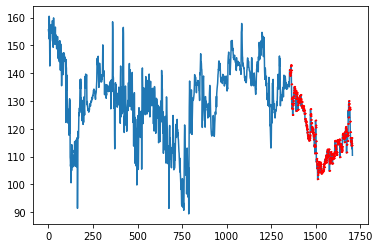

In [8]:

# prepare data
#scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
#model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)